In [1]:
using RNN2D

using Flux

using Random
using LinearAlgebra
using Statistics

using DelimitedFiles
using JSON

┌ Info: Precompiling RNN2D [e72342ba-bbd2-455e-85f3-60f54bebac29]
└ @ Base loading.jl:1317


In [2]:
data_path = "ED_L=3_Rb=1.2_delta=1.12_samples.dat"
psi_path = "true_psi_L=3_Rb=1.2_delta=1.12.dat"

labels = 0:1
width = 5
batch_size = 100
lr = 0.001
num_samples = 10_000 # number of samples to calculate for observables during training

epochs = 10 # number of training cycles per chk
period = 2 # after this many epochs, save training metrics
chk = 5 # number of times to save 

# Rydberg parameters
Rb = 1.2
delta = 1.12

nspins, num_batches, batched_data, psi, test_data = format_input_data(data_path, batch_size, labels; psi_path=psi_path, test_size=1000)

L = Int(sqrt(nspins))

m = Chain(
    RNNCell2D(length(labels), width), 
    Flux.Dense(width, length(labels))
)

# RNN file name to be used for saving things
RNN_ID = "2DRNN_L=$(L)_delta=$(delta)_Rb=$(Rb)_width=$(width)"

"2DRNN_L=3_delta=1.12_Rb=1.2_width=5"

In [3]:
space = format_data(generate_space(nspins), labels)
fidelity(target) = dot(target, sqrt.(probability(m, space, L, L, labels)))

function loss(x)
    mxs = apply_model(m, x, L, L, labels)
    sum(Flux.logitcrossentropy.(mxs, x))
end

opt = Flux.ADAM(lr)
# optimizer in DOI: 10.1103/PhysRevResearch.2.023358
#opt = Flux.Optimiser(ADAM(0.005), InvDecay(0.0002))

ADAM(0.001, (0.9, 0.999), IdDict{Any, Any}())

In [4]:
# From ED: E / N = -0.6432983319879794, SWAP = 0.973843871141432 (S2 = -log(SWAP))

vals = ["mean", "std_error", "variance"]
observables = ["energy_densities", "abs_stag_mags", "swaps"]
A = collect(1:(nspins ÷ 2))

observable_dict = Dict{String, Dict{String, Vector{Float64}}}()

starting_chk = 1

for c in starting_chk:chk
    
    # initialize things we need to save during training
    epoch_nums = collect(((c-1)*epochs + period):period:(epochs*c))
    for obs in observables
        observable_dict[obs] = Dict(k => [] for k in vals)
    end
    
    for e in 1:epochs
        batched_data = batched_data[shuffle(1:num_batches), :]
        for batch in batched_data
            Flux.train!(loss, Flux.params(m), [batch], opt)
        end

        if e % period == 0
            samples_info = sample_model(m, num_samples, L, L, labels)
            energy_density = rydberg_square_energy_density(m, samples_info, labels, Rb, delta)
            abs_stag_mag = abs_staggered_magnetization(samples_info)
            SWAP = swap(m, samples_info, labels, A)
            @show energy_density["mean"]
            @show abs_stag_mag["mean"]
            @show SWAP["mean"]
            @show fidelity(psi)

            for obs in observables
                
                # TODO: streamline this
                if obs == "energy_densities"
                    for k in vals
                        append!(observable_dict[obs][k], energy_density[k])
                    end
                end
                if obs == "abs_stag_mags"
                    for k in vals
                        append!(observable_dict[obs][k], abs_stag_mag[k])
                    end
                end
                if obs == "swaps"
                    for k in vals
                        append!(observable_dict[obs][k], SWAP[k])
                    end
                end
                
            end
            
        end
    end
    
    save_model(RNN_ID * "_model_chk=$c.bson", m)
    
    if c == 1
        # create a single dictionary to save epoch_data and all observables
        contents = Dict()
        for obs in observables
            contents[obs] = Dict{String, Vector{Float64}}()
            for k in vals
                contents[obs][k] = observable_dict[obs][k]
            end
        end
        
        contents["epochs"] = epoch_nums
        
    elseif c > 1
        previous_file_name = RNN_ID * "_chk=$(c-1)_observables.json"
        contents = JSON.parse(open(f->read(f, String), previous_file_name))
        
        for (obs, _) in contents
            if obs == "epochs"
                append!(contents["epochs"], epoch_nums)
            else
                for k in vals
                    append!(contents[obs][k], observable_dict[obs][k])
                end
            end
        end
    end
    
    observable_file = RNN_ID * "_chk=$(c)_observables.json"

    # save data
    open(observable_file, "w") do f
        write(f, JSON.json(contents))
    end
    
    # remove old observable file, but keep the previous one just in case
    old_observable_file_name = RNN_ID * "_chk=$(c-2)_observables.json"
    if isfile(old_observable_file_name)
        rm(old_observable_file_name)
    end
        
    # remove old model file, but keep the previous one just in case
    old_model_file_name = RNN_ID * "_model_chk=$(c-2).bson"
    if isfile(old_model_file_name)
        rm(old_model_file_name)
    end
    
end

energy_density["mean"] = -0.6411419593219035
abs_stag_mag["mean"] = 0.3226888888888889
SWAP["mean"] = 0.9660472000759058
fidelity(psi) = 0.9973110875665601
energy_density["mean"] = -0.6417367085947985
abs_stag_mag["mean"] = 0.3187888888888889
SWAP["mean"] = 0.9709581087094405
fidelity(psi) = 0.9979828824704942
energy_density["mean"] = -0.6420031682151645
abs_stag_mag["mean"] = 0.3235
SWAP["mean"] = 0.9715024829371623
fidelity(psi) = 0.9984941366515447
energy_density["mean"] = -0.6422029615857973
abs_stag_mag["mean"] = 0.32541111111111115
SWAP["mean"] = 0.9755164036108032
fidelity(psi) = 0.9984411871321834
energy_density["mean"] = -0.6417691030894999
abs_stag_mag["mean"] = 0.3155666666666667
SWAP["mean"] = 0.9716471365315424
fidelity(psi) = 0.9980010262069606
energy_density["mean"] = -0.6421729885014502
abs_stag_mag["mean"] = 0.3257666666666667
SWAP["mean"] = 0.9757778922256198
fidelity(psi) = 0.9986710991659349
energy_density["mean"] = -0.6425475981324509
abs_stag_mag["mean"] = 0.32602

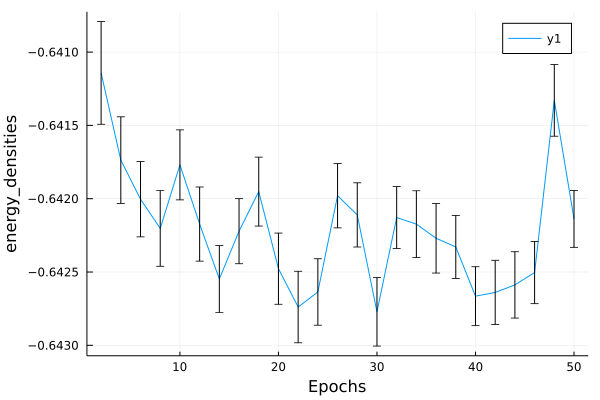

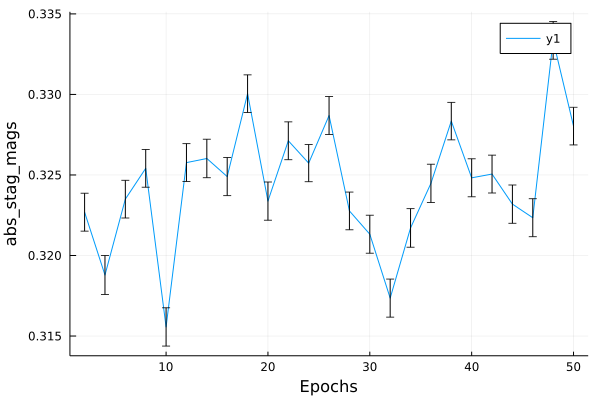

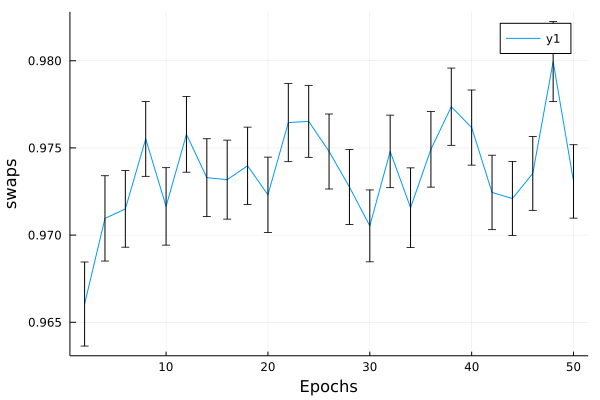

In [5]:
using Plots

observable_file = RNN_ID * "_chk=5_observables.json"
contents = JSON.parse(open(f->read(f, String), observable_file))

#open(observable_file, "r") do f
#    contents = JSON.parse(f)
#end

for obs in observables
    display(plot(
        contents["epochs"], contents[obs]["mean"], yerror=contents[obs]["std_error"], 
        fmt = :png, xlabel = "Epochs", ylabel = obs
    ))
end

In [6]:
starting_chk = 6
chk = 10
model = load_model("2DRNN_L=3_delta=1.12_Rb=1.2_width=5_model_chk=5.bson")

for c in starting_chk:chk
    
    # initialize things we need to save during training
    epoch_nums = collect(((c-1)*epochs + period):period:(epochs*c))
    for obs in observables
        observable_dict[obs] = Dict(k => [] for k in vals)
    end
    
    for e in 1:epochs
        batched_data = batched_data[shuffle(1:num_batches), :]
        for batch in batched_data
            Flux.train!(loss, Flux.params(m), [batch], opt)
        end

        if e % period == 0
            samples_info = sample_model(m, num_samples, L, L, labels)
            energy_density = rydberg_square_energy_density(m, samples_info, labels, Rb, delta)
            abs_stag_mag = abs_staggered_magnetization(samples_info)
            SWAP = swap(m, samples_info, labels, A)
            @show energy_density

            for obs in observables
                # TODO: streamline this
                if obs == "energy_densities"
                    for k in vals
                        append!(observable_dict[obs][k], energy_density[k])
                    end
                end
                if obs == "abs_stag_mags"
                    for k in vals
                        append!(observable_dict[obs][k], abs_stag_mag[k])
                    end
                end
                if obs == "swaps"
                    for k in vals
                        append!(observable_dict[obs][k], SWAP[k])
                    end
                end
            end
            
        end
    end
    
    save_model(RNN_ID * "_model_chk=$c.bson", m)

    previous_file_name = RNN_ID * "_chk=$(c-1)_observables.json"
    contents = JSON.parse(open(f->read(f, String), previous_file_name))

    for (obs, _) in contents
        if obs == "epochs"
            append!(contents["epochs"], epoch_nums)
        else
            for k in vals
                append!(contents[obs][k], observable_dict[obs][k])
            end
        end
    end
    
    observable_file = RNN_ID * "_chk=$(c)_observables.json"

    # save data
    open(observable_file, "w") do f
        write(f, JSON.json(contents))
    end
    
    # remove old observable file, but keep the previous one just in case
    old_observable_file_name = RNN_ID * "_chk=$(c-2)_observables.json"
    if isfile(old_observable_file_name)
        rm(old_observable_file_name)
    end
        
    # remove old model file, but keep the previous one just in case
    old_model_file_name = RNN_ID * "_model_chk=$(c-2).bson"
    if isfile(old_model_file_name)
        rm(old_model_file_name)
    end
    
end

energy_density = Dict("variance" => 0.0004992246589913428, "std_error" => 0.0002234333589666822, "mean" => -0.6422649672516423)
energy_density = Dict("variance" => 0.0003965725631738716, "std_error" => 0.00019914129736794216, "mean" => -0.6423965799197162)
energy_density = Dict("variance" => 0.0005109741240414287, "std_error" => 0.00022604736761162, "mean" => -0.6421830519451042)
energy_density = Dict("variance" => 0.0005008055682330634, "std_error" => 0.000223786855787614, "mean" => -0.6423260100414379)
energy_density = Dict("variance" => 0.0005362582850940698, "std_error" => 0.00023157251242193446, "mean" => -0.642781742864237)
energy_density = Dict("variance" => 0.0004456341125821787, "std_error" => 0.0002111004766887509, "mean" => -0.6423371840680455)
energy_density = Dict("variance" => 0.0005087778299078185, "std_error" => 0.00022556104049853523, "mean" => -0.6423249093772087)
energy_density = Dict("variance" => 0.00048030113794224143, "std_error" => 0.00021915773724471638, "mean"

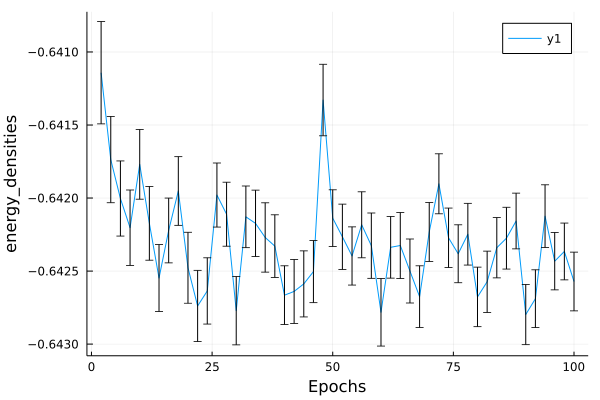

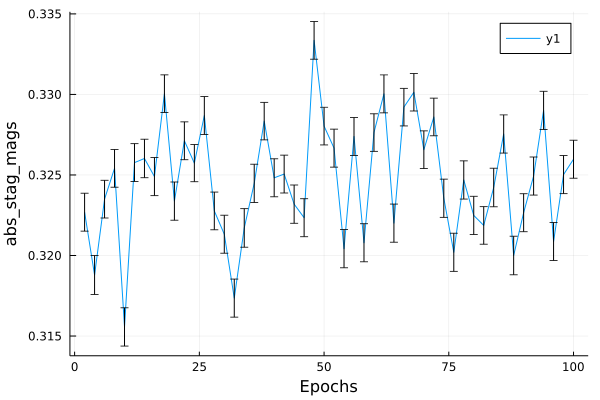

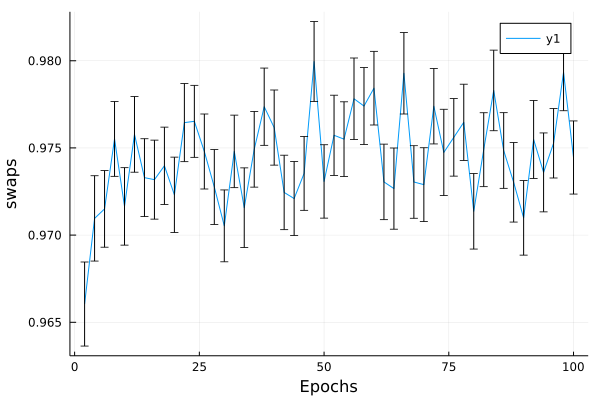

In [7]:
observable_file = RNN_ID * "_chk=10_observables.json"
contents = JSON.parse(open(f->read(f, String), observable_file))

for obs in observables
    display(plot(
        contents["epochs"], contents[obs]["mean"], yerror=contents[obs]["std_error"], 
        fmt = :png, xlabel = "Epochs", ylabel = obs
    ))
end

In [8]:
# for testing the sampling algorithm in test_sampling.ipynb

probs = probability(m, space, L, L, labels)
prob_samples, samples = sample_model(m, 1000, L, L, labels)
@show prob_samples == probability(m, format_data(samples, labels), L, L, labels)

saved_weight_mat = m[1].Wih
save_model("2DRNN_L=3_delta=1.12_Rb=1.2.bson", m)
model = load_model("2DRNN_L=3_delta=1.12_Rb=1.2.bson")
loaded_weight_mat = model[1].Wih

@show saved_weight_mat == loaded_weight_mat

# save the RNN wavefunction and samples to use in test_sampling.ipynb
open("2Drnn_psi.dat", "w") do io
    writedlm(io, sqrt.(probs))
end

samples = Int.(samples)

open("2Drnn_samples.dat", "w") do io
    writedlm(io, samples)
end

prob_samples == probability(m, format_data(samples, labels), L, L, labels) = true
saved_weight_mat == loaded_weight_mat = true
